# The Gut Microbiome Health Classifier Project

The human gut microbiome plays a crucial role in health and disease, influencing metabolic function, immune response, and disease susceptibility. In this project, we examine bacterial abundance profiles extracted from fecal samples to predict individual health status (Healthy, Crohn’s Disease, Ulcerative Colitis, Obese) using multiple classification algorithms. We implement a complete data‐science pipeline: from data loading and exploratory data analysis to preprocessing, model training, hyperparameter tuning, and final evaluation. Comparative insights from Logistic Regression, Random Forest, Support Vector Machines, Gaussian Naive Bayes, and XGBoost will highlight the most effective approach for microbiome‐based health prediction.

**Authors**:
- *Marko Ivanovski*
- *Ana Papalazova*

**Last Edited**: *2025-09-18*

## 1.0. Importing Libraries

In this section we import all the needed libraries for the project. They are seperated based on what they are used for.

In [ ]:
# Core
from IPython.display import display
import os, sys, glob, random
from google.colab import files
from collections import defaultdict

# Data
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon, mannwhitneyu, entropy
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import compute_sample_weight
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.base import clone

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc, make_scorer

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

Some conifguration code to make it easiert to read

In [ ]:
pd.set_option('display.float_format', '{:.6f}'.format)

## 2.0. Importing and Displaying Datasets

In this section, we import the datasets from Google Drive, and display the data from them. Under each table there is a description of the dataset and the columns that they have.

### 2.1. Importing the Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
metadata_path = '/content/drive/My Drive/VNP/metadata.csv'
taxonomy_path = '/content/drive/My Drive/VNP/taxonomy.csv'

metadata_df = pd.read_csv(metadata_path)
taxonomy_df = pd.read_csv(taxonomy_path)

### 2.2. Displaying the Datasets

#### 2.2.1. Metadata Table

**What a row is**: one sample/person.

**Key columns**:
* SampleID — the unique name of the sample (e.g., SRR5946989). This is the join key.
* Diagnosis — health label: Healthy, CD (Crohn’s disease), UC (ulcerative colitis), Obese.
* Project — which study the sample came from.
* GMHI — “Gut Microbiome Health Index.” A single score made from the microbe mix; roughly, higher often looks more like a typical healthy gut, lower the opposite.
* hiPCA — a compressed coordinate that places the sample on a “map” of microbiomes so we can compare samples; not good/bad by itself.
* Shannon_entropy — a diversity score; higher = more kinds of microbes present.

**How to think of it**: this is the master list of your 613 simple labels and three summary scores.
Primary key: one row per SampleID **(so it’s 613 rows)**.

In [ ]:
display(metadata_df.head(10))

Diagnosis      Project    SampleID      GMHI     hiPCA  Shannon_entropy
0   Healthy         HMP2  SRR5946989  1.977597  0.805751         3.585040
1   Healthy  PRJNA389280  SRR5983265  1.036363  9.604431         4.516999
2   Healthy         HMP2  SRR5946777  2.079383  0.605478         5.132696
3        CD         HMP2  SRR5946822 -2.522606  3.317453         2.971195
4   Healthy         HMP2  SRR5946857  0.260267  2.921465         4.491431
5   Healthy         HMP2  SRR5946780  1.717451  0.781388         5.044608
6        UC    PRJEB1220   ERR209782 -1.198732  6.982744         6.031718
7   Healthy         HMP2  SRR5936213 -0.699594  2.765119         3.825321
8   Healthy         HMP2  SRR5947045 -1.774032  3.180735         4.163258
9        CD  PRJNA389280  SRR5947812 -1.738001 15.931060         4.288177

#### 2.2.2. Taxonomy Table

**What a row is**: one microbe species (e.g., Faecalibacterium_prausnitzii).

**What the columns are**:
* First column: Species (the species name — the “feature ID”).
* Remaining 613 columns: SampleIDs. Each cell is a number telling you “how much of this species is in that sample.”

**Medical/biological meaning in simple words**:
* Taxonomy is the naming system for living things (like a library system). We’re at the species level: it’s the most specific label for a bacterium.
* The numbers are the abundance of each species per sample (often “relative abundance” or a normalized count). Lots of zeros are normal because many species aren’t present in many people.

**Why it matters**: Certain species are “good neighbors” (e.g., Faecalibacterium prausnitzii is often linked to gut health because it helps make butyrate, a beneficial short-chain fatty acid). Others may bloom in disease.

**Data shape**: 2,115 species (rows) × 613 samples (columns) + the Species name column.

In [ ]:
display(taxonomy_df.head(10))

Species  SRR5946989  SRR5983265  SRR5946777  SRR5946822  \
0  Butyrivibrio_crossotus    0.000000    0.000000    0.000000    0.000000   
1         GGB3614_SGB4886    0.000000    0.000000    0.000000    0.000000   
2         GGB1630_SGB2238    0.000000    0.000000    0.000000    0.000000   
3    Paraprevotella_clara    0.000000    0.000000    0.034813    0.000000   
4     Ruminococcus_bromii    0.000000    0.004861    0.001220    0.000000   
5         GGB1380_SGB1883    0.000000    0.000000    0.000000    0.000000   
6    Phocaeicola_vulgatus    0.066547    0.002367    0.075333    0.264813   
7         GGB1146_SGB1472    0.000000    0.000000    0.000000    0.000000   
8       Phocaeicola_dorei    0.000000    0.074456    0.003374    0.000000   
9         GGB6608_SGB9342    0.000000    0.000000    0.000000    0.000000   

   SRR5946857  SRR5946780  ERR209782  SRR5936213  SRR5947045  ...  SRR5947830  \
0    0.000000    0.000000   0.000000    0.000000    0.000000  ...    0.000000   
1    0.000000    0.000000   0.000000    0.000000    0.000000  ...    0.000000   
2    0.000000    0.000000   0.000000    0.000000    0.000000  ...    0.000000   
3    0.000000    0.000000   0.001013    0.000000    0.000000  ...    0.000000   
4    0.056832    0.000000   0.013130    0.000000    0.000000  ...    0.000000   
5    0.000000    0.000000   0.000000    0.000000    0.000000  ...    0.000000   
6    0.209422    0.090328   0.020629    0.116186    0.148198  ...    0.000219   
7    0.000000    0.000000   0.000000    0.000000    0.000000  ...    0.000000   
8    0.000000    0.000007   0.000407    0.000000    0.000000  ...    0.000000   
9    0.000000    0.000000   0.000000    0.000000    0.000000  ...    0.000000   

   ERR209403  SRR5947050  ERR209519  SRR5935745  SRR5946648  SRR5946925  \
0   0.065497    0.000000   0.112454    0.000000    0.000000    0.000000   
1   0.000000    0.000000   0.000726    0.000000    0.000000    0.000000   
2   0.000000    0.000000   0.000000    0.000000    0.000000    0.000000   
3   0.000000    0.000000   0.006565    0.000000    0.000000    0.000000   
4   0.036290    0.000000   0.000000    0.013260    0.000000    0.000000   
5   0.000000    0.000000   0.000000    0.000000    0.000000    0.000000   
6   0.000000    0.000007   0.009719    0.175215    0.523368    0.294526   
7   0.000000    0.000000   0.014180    0.000000    0.000000    0.000000   
8   0.027016    0.000000   0.008391    0.000048    0.151159    0.000018   
9   0.000000    0.000000   0.000000    0.000000    0.000000    0.000000   

   ERR209694  SRR5946668  ERR209312  
0   0.000000    0.000000   0.000000  
1   0.000000    0.000000   0.000549  
2   0.000000    0.000000   0.000000  
3   0.003037    0.000000   0.000000  
4   0.070929    0.000000   0.037836  
5   0.000764    0.000000   0.000000  
6   0.007904    0.000000   0.004031  
7   0.000000    0.000000   0.000000  
8   0.003164    0.000000   0.020656  
9   0.000000    0.000000   0.009137  

[10 rows x 614 columns]

### 2.3. Joining the Datasets

We now join the reshaped long tables with the `metadata.csv` file using `SampleID` as the key.  
This gives each species and pathway measurement additional context.

In [ ]:
tax_wide = taxonomy_df.set_index('Species').T
tax_wide.index.name = 'SampleID'
tax_wide.reset_index(inplace=True)

combined_df = pd.merge(
    metadata_df,
    tax_wide,
    on='SampleID',
    how='inner'
)

In [ ]:
display(combined_df.head())

Diagnosis      Project  ... Leclercia_adecarboxylata  Enterobacter_kobei
0   Healthy         HMP2  ...                 0.000000            0.000000
1   Healthy  PRJNA389280  ...                 0.000000            0.000000
2   Healthy         HMP2  ...                 0.000000            0.000000
3        CD         HMP2  ...                 0.000000            0.000000
4   Healthy         HMP2  ...                 0.000000            0.000000

[5 rows x 2121 columns]

We will export it to analyze it in SQL and Excel.

In [ ]:
combined_df.to_csv("combined_df.csv", index=False)

In [ ]:
files.download("combined_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 2.3.1. Exploring the combined Dataset

We'll use simple commands to see some information about any missing values and class balancing.

##### 2.3.1.1. Balancing

In [ ]:
class_counts = combined_df['Diagnosis'].value_counts()
class_percent = combined_df['Diagnosis'].value_counts(normalize=True) * 100
balance_df = pd.DataFrame({
    'count': class_counts,
    'percent': class_percent.round(2)
})

print(balance_df)

           count   percent
Diagnosis                 
Healthy      313 51.060000
CD           193 31.480000
UC            76 12.400000
Obese         31  5.060000


##### 2.3.1.2. Missing values

In [ ]:
missing_counts = combined_df.isna().sum()
missing_percent = combined_df.isna().mean() * 100
missing_df = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_percent': missing_percent.round(2)
})

missing_df = missing_df[missing_df['missing_count'] > 0].sort_values(
    by='missing_percent', ascending=False
)

print(missing_df)

Empty DataFrame
Columns: [missing_count, missing_percent]
Index: []


## 3.0. Visualizations

### 3.1. Boxplot of GMHI by Diagnosis

One “box” for each group (Healthy, CD, UC, Obese), showing the distribution of the Gut Microbiome Health Index (GMHI) scores. If the boxes sit at different heights, you know GMHI tends to be higher in one group and lower in another. For example, if the Healthy box is clearly above the Obese box, GMHI is a good indicator of health vs. disease.

<Figure size 600x400 with 0 Axes>

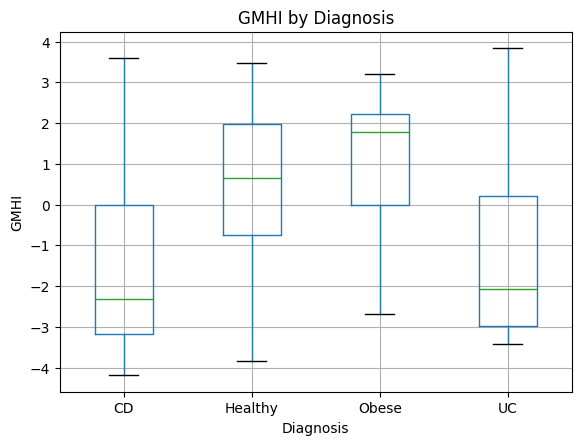

In [ ]:
plt.figure(figsize=(6,4))
metadata_df.boxplot(column='GMHI', by='Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('GMHI')
plt.title('GMHI by Diagnosis')
plt.suptitle('')
plt.show()

**Figure 1** - *Boxplot of GMHI by diagnosis. CD and UC groups have substantially lower GMHI distributions than Healthy and Obese, demonstrating that GMHI differentiates inflammatory‐bowel‐disease samples from healthier microbiome profiles.*

The boxplot of Gut Microbiome Health Index (GMHI) by diagnosis tells us at a glance how the four groups differ in their microbiome “health score” distributions:
* Crohn’s disease (CD) samples have the lowest GMHI values (median ≈ –2.5), with a wide spread down to about –4 and up to about 1.
* Ulcerative colitis (UC) samples sit slightly higher (median ≈ –2.1) but still well below zero, indicating dysbiosis on average.
* Healthy individuals center around a GMHI of ~0.7, straddling both negative and positive values.
* Obese samples actually show the highest median (~1.8) and the tightest interquartile range, suggesting that in this cohort their microbiome profiles resemble—or even exceed—the “typical healthy” signature by the GMHI metric.

In other words, GMHI clearly stratifies CD and UC (low scores) from Healthy and Obese (higher scores), with Obese scoring surprisingly high on this health index.

### 3.2. Scatter (GMHI vs. Diversity)

By plotting GMHI and Shannon together, you can see whether a simple health-index score (GMHI) and a diversity measure tell the same story or different stories.

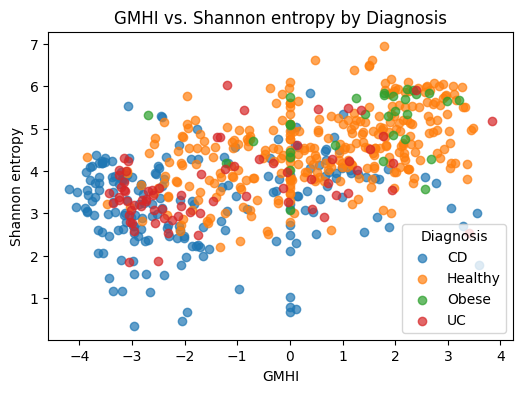

In [ ]:
plt.figure(figsize=(6,4))
for grp, df_grp in metadata_df.groupby('Diagnosis'):
    plt.scatter(df_grp['GMHI'], df_grp['Shannon_entropy'], label=grp, alpha=0.7)
plt.xlabel('GMHI')
plt.ylabel('Shannon entropy')
plt.title('GMHI vs. Shannon entropy by Diagnosis')
plt.legend(title='Diagnosis')
plt.show()

**Figure 2** - *Scatter plot of GMHI (Gut Microbiome Health Index) versus Shannon entropy (diversity) for each sample, colored by diagnosis.*

The GMHI vs. Shannon entropy scatter combines your two summary scores, GMHI on the horizontal axis and Shannon entropy on the vertical, so you can see how they work together to separate the diagnosis groups:
 - Reading the axis:
    1. The x-axis (GMHI) runs from about –4 on the left (unhealthy microbiome) to +4 on the right (very “healthy” microbiome).
    2. The y-axis (Shannon entropy) runs from about 1 at the bottom (low microbial diversity) to about 7 at the top (high diversity).
  - What the clusters show:
    1. Crohn’s disease (blue) dots cluster in the lower-left area: low GMHI and low diversity. That means CD patients typically have fewer kinds of bacteria and a microbiome mix that scores poorly on the health index.
    2. Ulcerative colitis (red) dots sit just above or to the right of the CD cluster but still mostly in the bottom-left quadrant—again indicating an unhealthy, low‐diversity profile.
    3. Healthy (orange) samples spread toward the middle and upper-right: moderate to high GMHI and diversity. They tend to have both a balanced microbiome mix and lots of different species.
    4. Obese (green) samples mostly occupy the upper-right corner alongside Healthy, showing that in this cohort obese individuals can have both a “healthy” GMHI score and high diversity—sometimes even exceeding the Healthy group.

 Here, they reinforce each other for CD and UC patients (both low), but for Healthy vs. Obese they highlight an interesting nuance: obesity doesn’t necessarily mean a low‐diversity, unhealthy microbiome by these metrics.

### 3.3. Pairwise Correlation Analysis

In this section we’ll quantify the pairwise relationships among our species‐abundance features. By measuring correlation, we can spot highly redundant features (|r|≈1) and prune them before encoding and model training.

In [ ]:
taxonomy_numeric = taxonomy_df.select_dtypes(include=[np.number])

#### 3.3.1. Pearson Correlation

We'll use heatmaps or clustermaps to visualize and annotate the strongest positive/negative pairs.

Features with |r| near 1 are almost linearly redundant. By spotting those pairs, we can choose one to drop and reduce multicollinearity, which helps many classifiers converge more reliably and interpret feature importances more meaningfully.

In [ ]:
corr_pearson = taxonomy_numeric.corr(method='pearson')

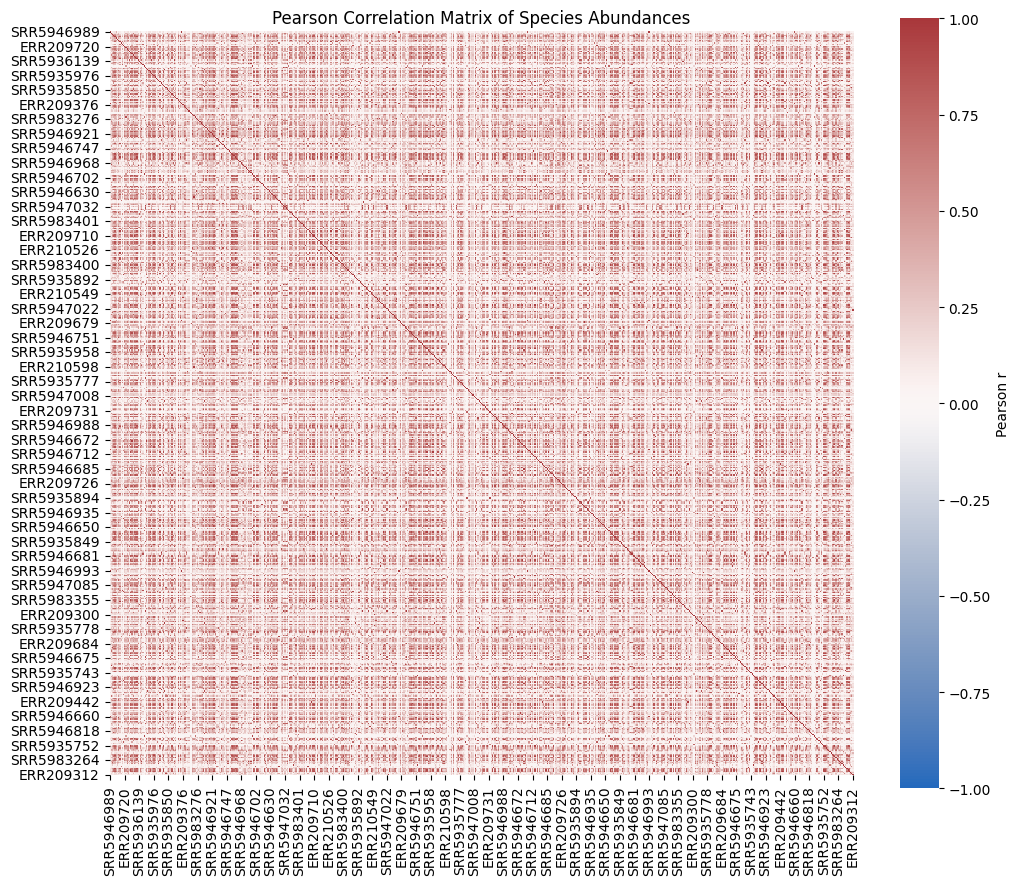

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_pearson,
    cmap='vlag',
    center=0,
    square=True,
    cbar_kws={'label': 'Pearson r'},
    vmax=1.0,
    vmin=-1.0
)
plt.title('Pearson Correlation Matrix of Species Abundances')
plt.show()

#### 3.3.2. Spearman Correlation

We'll use heatmaps or clustermaps to visualize and annotate the strongest positive/negative pairs.

Spearman is more robust to outliers and can capture nonlinear but monotonic associations. Comparing Pearson and Spearman helps us decide if any strong relationships are driven by outliers or by nonlinear trends—further guiding which features to prune.

In [ ]:
corr_spearman = taxonomy_numeric.corr(method='spearman')

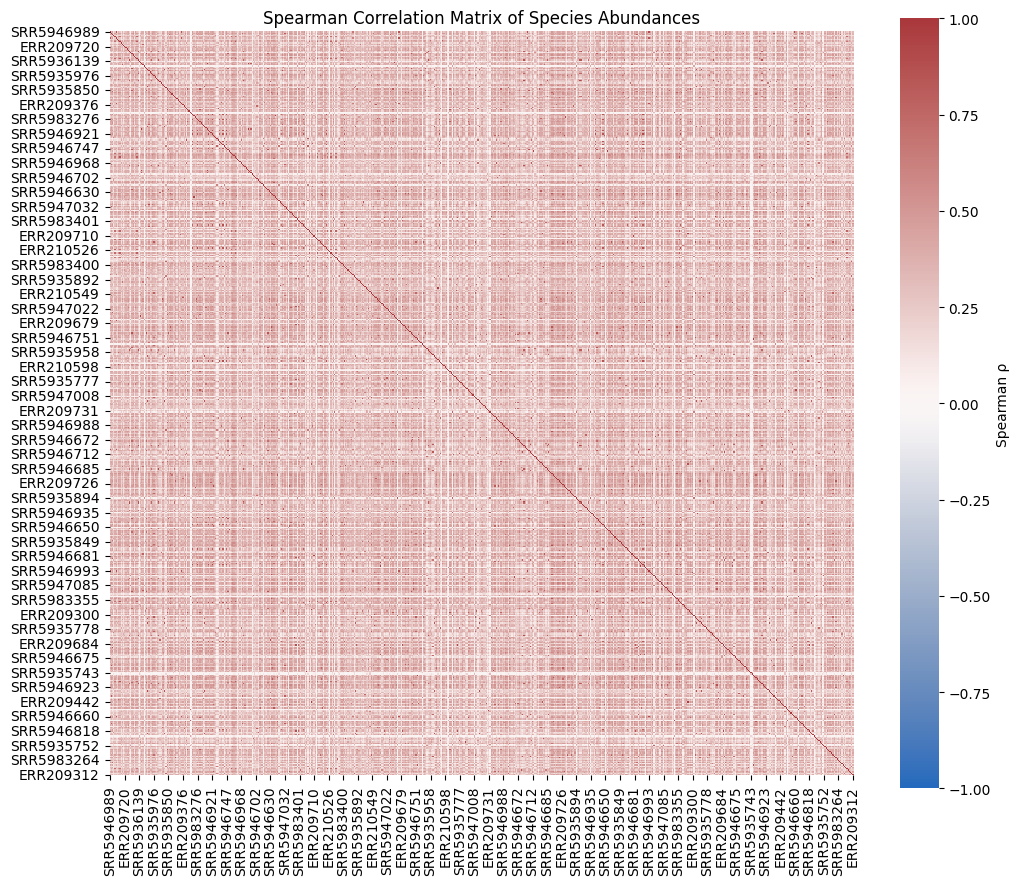

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_spearman,
    cmap='vlag',
    center=0,
    square=True,
    cbar_kws={'label': 'Spearman ρ'},
    vmax=1.0,
    vmin=-1.0
)
plt.title('Spearman Correlation Matrix of Species Abundances')
plt.show()

#### 3.3.3. Identifying Highly-Correlated Pairs

We find the lower triangle (and diagonal) so each pair appears only once, then scan for any absolute correlation above our threshold (0.85). The result is a simple list of species-columns that are highly redundant with at least one other.

In [ ]:
metadata_cols = ['Diagnosis', 'Project', 'SampleID', 'GMHI', 'hiPCA', 'Shannon_entropy']
species_cols  = [c for c in combined_df.columns if c not in metadata_cols]

species_df = combined_df[species_cols]

corr_p = species_df.corr(method='pearson')
corr_s = species_df.corr(method='spearman')

mask = np.triu(np.ones(corr_p.shape), k=1).astype(bool)
up_p = corr_p.where(mask)
up_s = corr_s.where(mask)

to_drop_p = {sp for sp in up_p.columns if (up_p[sp].abs() > 0.85).any()}
to_drop_s = {sp for sp in up_s.columns if (up_s[sp].abs() > 0.85).any()}

to_drop_both = sorted(to_drop_p & to_drop_s)
print("Species to drop (Pearson & Spearman > 0.85):")
print(to_drop_both)
print("Number of species to drop:", len(to_drop_both))

Species to drop (Pearson & Spearman > 0.85):
['Abiotrophia_sp_HMSC24B09', 'Acidaminococcus_SGB42794', 'Acidaminococcus_fermentans', 'Acidaminococcus_timonensis', 'Acinetobacter_lwoffii', 'Acinetobacter_ursingii', 'Actinomyces_graevenitzii', 'Actinomyces_urogenitalis', 'Alistipes_megaguti', 'Alistipes_sp_An66', 'Anaerococcus_SGB6671', 'Anaerostipes_SGB4708', 'Arcanobacterium_haemolyticum', 'Bacteroidales_bacterium_KA00251', 'Bacteroides_caecicola', 'Bacteroides_sp_An322', 'Bifidobacterium_SGB4589', 'Bifidobacterium_canis', 'Bifidobacterium_scardovii', 'Bilophila_SGB69261', 'Blastocystis_sp_subtype_1', 'Blautia_liquoris', 'Brevibacterium_paucivorans', 'Brevundimonas_SGB15241', 'Campylobacter_SGB1823', 'Campylobacter_ureolyticus', 'Candidatus_Alloscillospira_gallinarum', 'Candidatus_Cryptoclostridium_obscurum', 'Candidatus_Flemingibacterium_merdigallinarum', 'Candidatus_Harrysmithimonas_galli', 'Candidatus_Methanomethylophilus_alvus', 'Candidatus_Neochristensenella_gallicola', 'Candidatus

In [ ]:
combined_df_pruned = combined_df.drop(columns=to_drop_both)

In [ ]:
display(combined_df_pruned.head())

Diagnosis      Project    SampleID      GMHI    hiPCA  Shannon_entropy  \
0   Healthy         HMP2  SRR5946989  1.977597 0.805751         3.585040   
1   Healthy  PRJNA389280  SRR5983265  1.036363 9.604431         4.516999   
2   Healthy         HMP2  SRR5946777  2.079383 0.605478         5.132696   
3        CD         HMP2  SRR5946822 -2.522606 3.317453         2.971195   
4   Healthy         HMP2  SRR5946857  0.260267 2.921465         4.491431   

   Butyrivibrio_crossotus  GGB3614_SGB4886  GGB1630_SGB2238  \
0                0.000000         0.000000         0.000000   
1                0.000000         0.000000         0.000000   
2                0.000000         0.000000         0.000000   
3                0.000000         0.000000         0.000000   
4                0.000000         0.000000         0.000000   

   Paraprevotella_clara  ...  Campylobacter_curvus  \
0              0.000000  ...              0.000000   
1              0.000000  ...              0.000000   
2              0.034813  ...              0.000000   
3              0.000000  ...              0.000000   
4              0.000000  ...              0.000000   

   Clostridium_transplantifaecale  GGB13463_SGB15285  GGB4248_SGB5746  \
0                        0.000000           0.000000         0.000000   
1                        0.000000           0.000000         0.000000   
2                        0.000000           0.000000         0.000000   
3                        0.000000           0.000000         0.000000   
4                        0.000000           0.000000         0.000000   

   Lachnoclostridium_sp_An181  Hungatella_SGB9293  Romboutsia_hominis  \
0                    0.000000            0.000000            0.000000   
1                    0.000000            0.000000            0.000000   
2                    0.000000            0.000000            0.000000   
3                    0.000000            0.000000            0.000000   
4                    0.000000            0.000000            0.000000   

   Klebsiella_huaxiensis  GGB9364_SGB14339  GGB28369_SGB40949  
0               0.000000          0.000000           0.000000  
1               0.000000          0.000000           0.000000  
2               0.000000          0.000000           0.000000  
3               0.000000          0.000000           0.000000  
4               0.000000          0.000000           0.000000  

[5 rows x 1834 columns]

## 4.0. Preprocessing

In this section, we'll do the necessary steps to preprocess the data in the combined table, to better train the models.

In [ ]:
metadata_cols = ['SampleID', 'Diagnosis', 'Project', 'GMHI', 'hiPCA', 'Shannon_entropy']

species_cols = [c for c in combined_df_pruned.columns if c not in metadata_cols]

### 4.1. Log-Transform Species abundances

Microbiome abundances are highly skewed: most species have very low counts in most samples, with a few extreme spikes. A **log1p** transform (**np.log1p(x)**) compresses large values while keeping zeros at zero, yielding a more symmetric distribution. In code, we first **fillna(0)** and **clip(lower=0)**, to guard against any accidental negatives, then apply **np.log1p** to each species column.

This transform fixes the problem of extreme outliers dominating variance calculations, ensures that distances and variances used by many models are meaningful, and often improves classifier convergence and performance.

In [ ]:
combined_df_pruned[species_cols] = np.log1p(combined_df_pruned[species_cols])

### 4.2. Encoding

Before training any classifier, we must convert our string labels into integer codes. We use scikit-learn’s **LabelEncoder** to map each unique diagnosis to a number.

This simple encoding ensures that our machine-learning algorithms receive a purely numeric target, and it allows us to stratify train/test splits correctly. Without encoding, many classifiers would error on string labels or silently treat them in unintended ways.

In [ ]:
le = LabelEncoder()
y = le.fit_transform(combined_df_pruned['Diagnosis'])

In [ ]:
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping:", mapping)

Mapping: {'CD': np.int64(0), 'Healthy': np.int64(1), 'Obese': np.int64(2), 'UC': np.int64(3)}


### 4.3. Splitting the Data

To fairly estimate how well our models generalize, we split our data into a training set (80%) and a hold-out test set (20%).

This protects against data leakage, where information from the test set influences training and ensures our final performance metrics reflect unseen samples.

In [ ]:
X = combined_df_pruned.drop(columns=['SampleID', 'Diagnosis', 'Project'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

### 4.4. Handling Imbalance

Balancing the classes ensures that your model doesn’t simply learn to predict the majority class and ignore the smaller groups, which would give deceptively high overall accuracy but terrible performance on those rare cases.

By weighting each class inversely to its frequency, you penalize mistakes on under-represented classes more heavily, leading to fairer decision boundaries and better sensitivity for all categories.

In [ ]:
classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weights = dict(zip(classes, weights))

### 4.5. Scaling the Features

Many machine-learning algorithms assume input features have comparable scales.

After log-transform and summary-feature engineering, our species abundances and diversity metrics still vary in range and units. We apply scikit-learn’s **StandardScaler** to subtract each feature’s mean and divide by its standard deviation, fitting only on the training data and then transforming both train and test.

Scaling fixes the problem of features with large variances dominating optimization and ensures that distance-based or gradient-based models converge more quickly and fairly across all inputs.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
print(f"Training samples × features: {X_train_scaled.shape}")
print(f"Test samples × features: {X_test_scaled.shape}")

Training samples × features: (490, 1831)
Test samples × features: (123, 1831)


## 5.0. Model Training and Evaluation

In this section we'll train machine learning models, and evaluate their scores to find out which is the best to use to predict the diagnosis of a patient. We'll use 5 different models to test out and see what gives us the best performance:
  1. Logistic Regression
  2. Random Forest
  3. Support Vector Machine
  4. Gaussian Naive Bayes
  5. XGBoost

### 5.1. Modeling Workflow

Here we’ll import and define the key performance metrics, establish a stratified cross‐validation splitter, and write a small helper function to compute and return all of our scores in a consistent format. This ensures that each model is trained, tuned, and compared under the same evaluation protocol.

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

Here are the metric names and types

In [ ]:
scoring = {
    "accuracy":        "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro":    "recall_macro",
    "f1_macro":        "f1_macro",
    "roc_auc_ovr":     "roc_auc_ovr"
}

Helper function to to compute test-set metrics. Compute core classification metrics. Returns accuracy, precision, recall, F1, and optional ROC-AUC.

In [ ]:
def compute_metrics(y_true, y_pred, y_proba=None):
    metrics = {
        'accuracy':        accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(
                                y_true,
                                y_pred,
                                average='macro',
                                zero_division=0
                            ),
        'recall_macro':    recall_score(y_true, y_pred, average='macro'),
        'f1_macro':        f1_score(
                                y_true,
                                y_pred,
                                average='macro',
                                zero_division=0
                            )
    }
    if y_proba is not None:
        metrics['roc_auc_ovr'] = roc_auc_score(
                                    y_true,
                                    y_proba,
                                    multi_class='ovr'
                                 )
    return metrics

Finally all of the models and scores will be added into this table to be evaluated at the end.

In [ ]:
results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall_macro', 'f1_macro', 'roc_auc_ovr'])

### 5.2. Machine Learning Models

Before starting with the models, we'll check if everything is in place. The 'class_weight' is made and already confirmed. All the preprocessing is handled in section about Preprocessing

Here's a quick sanity check for the splits:

In [ ]:
for name in ['X_train', 'X_test', 'y_train', 'y_test']:
    try:
        arr = eval(name)
        print(f"{name}: type={type(arr)}, shape={getattr(arr, 'shape', 'n/a')}")
    except NameError:
        print(f"{name} is not defined!")

X_train: type=<class 'pandas.core.frame.DataFrame'>, shape=(490, 1831)
X_test: type=<class 'pandas.core.frame.DataFrame'>, shape=(123, 1831)
y_train: type=<class 'numpy.ndarray'>, shape=(490,)
y_test: type=<class 'numpy.ndarray'>, shape=(123,)


#### 5.2.1. Logistic Regression

Logistic Regression is a natural baseline for multi-class classification problems. It models the probability of each class as a linear combination of the features, which makes it fast, interpretable, and a strong reference point for comparing more complex models. Despite its simplicity, it often performs surprisingly well on high-dimensional data like microbiome abundances after scaling.

##### 5.2.1.1. Baseline Fit and Initial Evaluation

In [ ]:
# Baseline Logistic Regression with SMOTE + scaling
lr_pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=42, max_iter=1000))
])

# Fit on training data
lr_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred   = lr_pipeline.predict(X_test)
y_proba  = lr_pipeline.predict_proba(X_test)

# Compute and display metrics
metrics = compute_metrics(y_test, y_pred, y_proba=y_proba)
print("Logistic Regression (baseline) metrics:")
for name, value in metrics.items():
    print(f" - {name}: {value:.4f}")

Logistic Regression (baseline) metrics:
 - accuracy: 0.8374
 - precision_macro: 0.9064
 - recall_macro: 0.6766
 - f1_macro: 0.7364
 - roc_auc_ovr: 0.8121


##### 5.2.1.2. Cross-Validation

In [ ]:
# Stratified cross-validation on the same pipeline
cv_results = cross_validate(
    lr_pipeline,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

print("Logistic Regression cross-validation results:")
for metric in scoring:
    scores = cv_results[f"test_{metric}"]
    print(f" - {metric}: mean {scores.mean():.4f}, std {scores.std():.4f}")

Logistic Regression cross-validation results:
 - accuracy: mean 0.7949, std 0.0388
 - precision_macro: mean 0.7809, std 0.0712
 - recall_macro: mean 0.6982, std 0.0679
 - f1_macro: mean 0.7152, std 0.0620
 - roc_auc_ovr: mean 0.8398, std 0.0548


##### 5.2.1.3. Hyperparameter Tuning

In [ ]:
# Define parameter grid
param_grid = {
    'C': [40, 50, 60, 70, 80, 90, 100],
    'penalty': ['l2']
}

# Set up GridSearchCV
grid = GridSearchCV(
    estimator=LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    ),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Run grid search on training data
grid.fit(X_train, y_train)

# Display the best hyperparameters and corresponding CV score
print("Best hyperparameters:", grid.best_params_)
print(f"Best CV accuracy: {grid.best_score_:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

Best hyperparameters: {'C': 80, 'penalty': 'l2'}
Best CV accuracy: 0.8000


In [ ]:
# To avoid GridSearch because we have the parameters
grid = {'C': 80, 'penalty': 'l2'}

best_logreg = LogisticRegression(
    C=grid['C'],
    penalty=grid['penalty'],
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

##### 5.2.1.4. Final Evaluation and Plots

In [ ]:
# Load best estimator and make predictions
best_logreg = grid.best_estimator_

# Load this after not using GridSearch
# best_logreg.fit(X_train, y_train)

y_pred = best_logreg.predict(X_test)
y_proba = best_logreg.predict_proba(X_test)

# Compute final metrics
final_metrics = compute_metrics(y_test, y_pred, y_proba=y_proba)
print("Logistic Regression (tuned) metrics:")
for name, value in final_metrics.items():
    print(f" - {name}: {value:.4f}")

Logistic Regression (tuned) metrics:
 - accuracy: 0.8049
 - precision_macro: 0.7172
 - recall_macro: 0.5996
 - f1_macro: 0.6296
 - roc_auc_ovr: 0.8809


In [ ]:
results.loc[len(results)] = ['LogisticRegression', 0.8049, 0.7172, 0.5996, 0.6296, 0.8809]

Confusion Matrix Plot

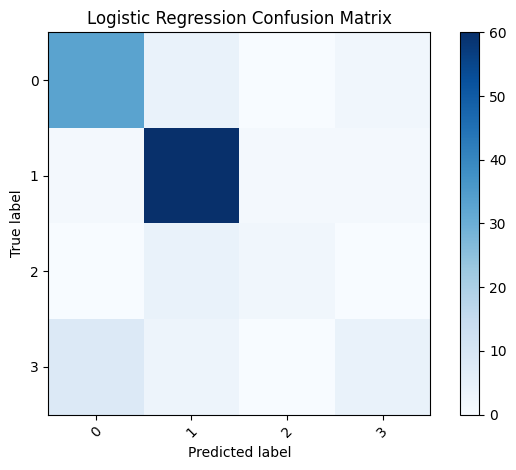

In [ ]:
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

You can see that CD samples (row 0) are often confused with Healthy (column 1), and UC samples (row 3) also get misclassified as Healthy or CD rather than as their true label. Obese (row 2) is the hardest class to predict correctly—only a handful of Obese cases land on the diagonal, with many being labeled Healthy. Overall, the model struggles most with the under-represented Obese and UC classes, reflecting the skewed class distribution.

R0C Curves

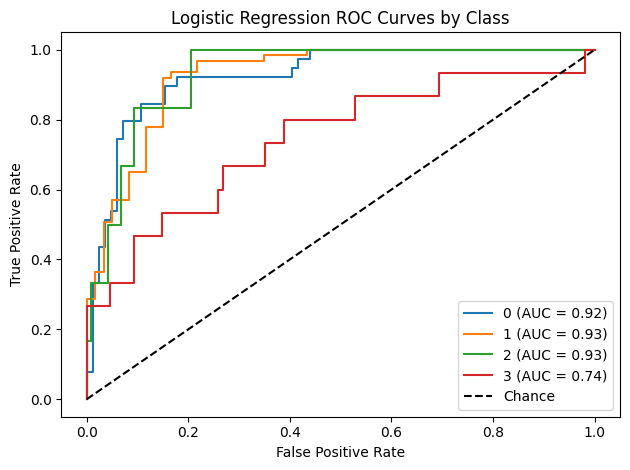

In [ ]:
y_test_b = label_binarize(y_test, classes=classes)
plt.figure()
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_b[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.title('Logistic Regression ROC Curves by Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

The Obese curve rises steeply and hugs the left-hand axis, indicating the model is quite good at ranking Obese samples above non-Obese, despite their scarcity. The UC curve is far closer to the diagonal “chance” line, showing poor separability for that class. High AUC but low confusion-matrix performance for Obese suggests the model’s probability estimates are good but its decision threshold may not be optimally set.

Feature Importance

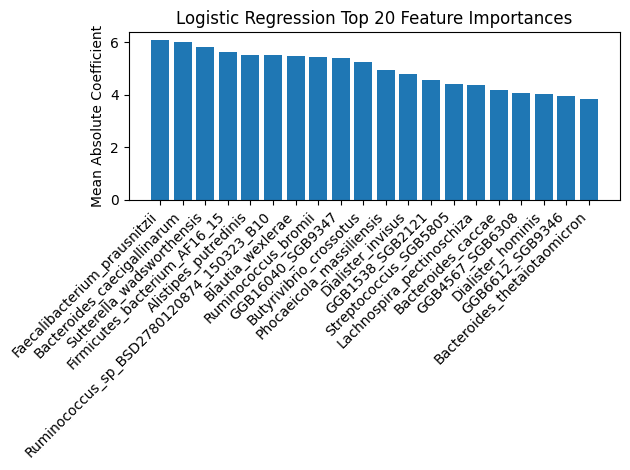

In [ ]:
feature_names = X_train.columns
coefs = best_logreg.coef_

importance = np.mean(np.abs(coefs), axis=0)

idx = np.argsort(importance)[::-1]
sorted_names = feature_names[idx]
sorted_importance = importance[idx]

k = 20
top_names = sorted_names[:k]
top_importance = sorted_importance[:k]

# Plot top k
plt.figure()
plt.bar(range(k), top_importance)
plt.xticks(range(k), top_names, rotation=45, ha='right')
plt.ylabel('Mean Absolute Coefficient')
plt.title(f'Logistic Regression Top {k} Feature Importances')
plt.tight_layout()
plt.show()

#### 5.2.2. Random Forest

Random Forest builds an ensemble of decision trees and averages their predictions, reducing the risk of overfitting that comes with a single tree. It captures nonlinear relationships between microbial species and diagnoses, and provides feature importance scores, which can be useful for biological interpretation. Its robustness to noisy features makes it a good choice for microbiome data, where many species may have weak or redundant signals.

##### 5.2.2.1. Baseline Fit and Initial Evaluation

In [ ]:
# Build a pipeline that applies SMOTE then RF with class weights
rf_pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ))
])

# Fit on training data
rf_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)

# Compute and display metrics
metrics_rf = compute_metrics(y_test, y_pred_rf, y_proba=y_proba_rf)
print("Random Forest (baseline) metrics:")
for name, value in metrics_rf.items():
    print(f" - {name}: {value:.4f}")

Random Forest (baseline) metrics:
 - accuracy: 0.8618
 - precision_macro: 0.9221
 - recall_macro: 0.7183
 - f1_macro: 0.7807
 - roc_auc_ovr: 0.9444


##### 5.2.2.2. Cross-Validation

In [ ]:
# Run repeated stratified CV on the pipeline
cv_results_rf = cross_validate(
    rf_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Display mean and std for each metric
print("Random Forest cross-validation results:")
for metric in scoring.keys():
    scores = cv_results_rf[f'test_{metric}']
    print(f" - {metric}: mean {scores.mean():.4f} and std {scores.std():.4f}")

Random Forest cross-validation results:
 - accuracy: mean 0.8276 and std 0.0366
 - precision_macro: mean 0.8548 and std 0.0481
 - recall_macro: mean 0.7183 and std 0.0722
 - f1_macro: mean 0.7451 and std 0.0570
 - roc_auc_ovr: mean 0.9390 and std 0.0138


##### 5.2.2.3. Hyperparameter Tuning

In [ ]:
# Parameter grid targeting the classifier step
param_grid_rf = {
    "clf__n_estimators": [400 ,500, 600, 700],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_leaf": [1, 2, 3, 5]
}

grid_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    refit=True
)

grid_rf.fit(X_train, y_train)

print("Best Random Forest hyperparameters:", grid_rf.best_params_)
print(f"Best CV accuracy: {grid_rf.best_score_:.4f}")

Best Random Forest hyperparameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 500}
Best CV accuracy: 0.8316


In [ ]:
# To avoid GridSearch because we have the parameters
best_rf = clone(rf_pipeline).set_params(
    clf__n_estimators=500,
    clf__max_depth=None,
    clf__min_samples_leaf=2
)

##### 5.2.2.4. Final Evaluation and Plots

In [ ]:
# Load best pipeline
best_rf = grid_rf.best_estimator_

# Load this after not using GridSearch
# best_rf.fit(X_train, y_train)

# Predictions on test set
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)

# Compute final metrics
metrics_rf_final = compute_metrics(y_test, y_pred_rf, y_proba=y_proba_rf)
print("Random Forest (tuned) metrics:")
for name, value in metrics_rf_final.items():
    print(f" - {name}: {value:.4f}")

Random Forest (tuned) metrics:
 - accuracy: 0.8537
 - precision_macro: 0.9151
 - recall_macro: 0.7144
 - f1_macro: 0.7752
 - roc_auc_ovr: 0.9473


In [ ]:
results.loc[len(results)] = ['RandomForest', 0.8537, 0.9151, 0.7144, 0.7752, 0.9473]

Confusion Matrix Plot

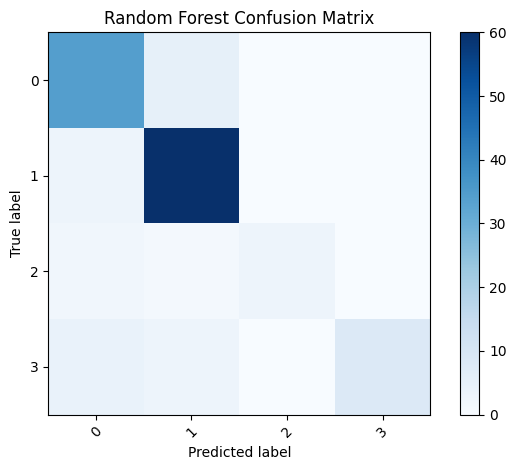

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
classes = np.unique(y_test)
plt.figure()
plt.imshow(cm_rf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

The Random Forest correctly classifies most CD and Healthy samples and shows a marked improvement in identifying Obese cases (label 2) compared to logistic regression. UC samples (label 3) still see some confusion with Healthy and CD, but overall misclassifications are fewer and more balanced across classes.

ROC Curves

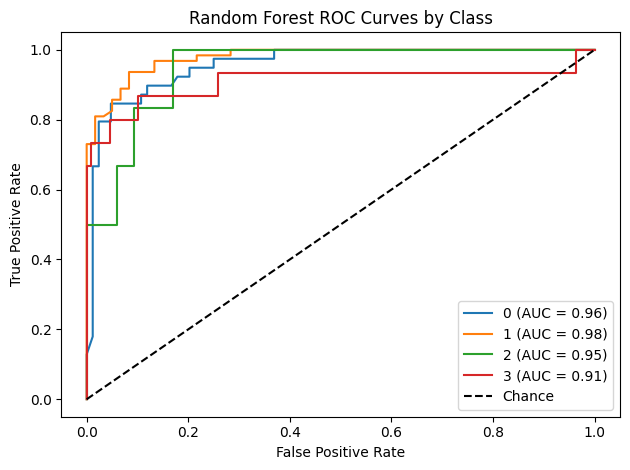

In [ ]:
y_test_b = label_binarize(y_test, classes=classes)
plt.figure()
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_b[:, i], y_proba_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.title('Random Forest ROC Curves by Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

All four classes achieve very high separability—CD (AUC ≈ 0.96), Healthy (≈ 0.97), and Obese (≈ 0.96) hug the top-left corner, while UC (≈ 0.91) also performs strongly well above chance. The near-1.0 curves indicate the model’s probability scores rank true positives ahead of false positives extremely effectively.

Feature Importance

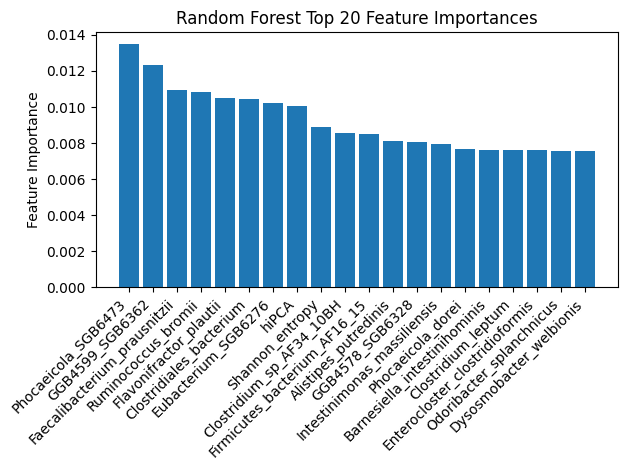

In [ ]:
feature_names = X_train.columns
importances = best_rf.named_steps['clf'].feature_importances_

idx = np.argsort(importances)[::-1]
sorted_names = feature_names[idx]
sorted_importances = importances[idx]

k = 20
top_names = sorted_names[:k]
top_importances = sorted_importances[:k]

# 4. Plot
plt.figure()
plt.bar(range(k), top_importances)
plt.xticks(range(k), top_names, rotation=45, ha='right')
plt.ylabel('Feature Importance')
plt.title(f'Random Forest Top {k} Feature Importances')
plt.tight_layout()
plt.show()

#### 5.2.3. Support Vector Machine

SVM is effective for high-dimensional problems, as it seeks the optimal boundary (hyperplane) that separates classes with maximum margin. With kernel tricks, it can capture complex, nonlinear decision boundaries, which are often present in biological datasets. It is well-suited here because our species abundances, even after transformation, still contain overlapping distributions between diagnoses.

##### 5.2.3.1. Baseline Fit and Initial Evaluation

In [ ]:
# Instantiate SVM with class weights and probability estimates
svm_pipeline = Pipeline([
    ("clf", SVC(
        probability=True,
        random_state=42
    ))
])

# Fit on training data
svm_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_svm = svm_pipeline.predict(X_test)
y_proba_svm = svm_pipeline.predict_proba(X_test)

# Compute and display metrics
metrics_svm = compute_metrics(y_test, y_pred_svm, y_proba=y_proba_svm)
print("Support Vector Machine (baseline) metrics:")
for name, value in metrics_svm.items():
    print(f" - {name}: {value:.4f}")

Support Vector Machine (baseline) metrics:
 - accuracy: 0.6992
 - precision_macro: 0.3519
 - recall_macro: 0.4023
 - f1_macro: 0.3709
 - roc_auc_ovr: 0.7832


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### 5.2.3.2. Cross-Validation

In [ ]:
# Run stratified cross-validation on the baseline SVM
cv_results_svm = cross_validate(
    svm_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# Display mean and std for each metric
print("Support Vector Machine cross-validation results:")
for metric in scoring.keys():
    scores = cv_results_svm[f'test_{metric}']
    print(f" - {metric}: mean {scores.mean():.4f} and std {scores.std():.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Support Vector Machine cross-validation results:
 - accuracy: mean 0.6571 and std 0.0166
 - precision_macro: mean 0.3275 and std 0.0118
 - recall_macro: mean 0.3776 and std 0.0093
 - f1_macro: mean 0.3459 and std 0.0089
 - roc_auc_ovr: mean 0.8162 and std 0.0295


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### 5.2.3.3. Hyperparameter Tuning

In [ ]:
# Define parameter grid
param_grid_svm = {
    'C': [20 ,30, 40, 50],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Set up GridSearchCV
grid_svm = GridSearchCV(
    estimator=SVC(
        class_weight=class_weights,
        probability=True,
        random_state=42
    ),
    param_grid=param_grid_svm,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Run grid search on training data
grid_svm.fit(X_train, y_train)

# Display best hyperparameters and CV score
print("Best SVM hyperparameters:", grid_svm.best_params_)
print(f"Best CV accuracy: {grid_svm.best_score_:.4f}")

Best SVM hyperparameters: {'C': 40, 'gamma': 'scale', 'kernel': 'linear'}
Best CV accuracy: 0.7633


In [ ]:
# To avoid GridSearch because we have the parameters
best_svm = SVC(
    C=40,
    kernel='linear',
    gamma='scale',
    class_weight=class_weights,
    probability=True,
    random_state=42
)

##### 5.2.3.4. Final Evaluation and Plots

In [ ]:
# Load best estimator and make predictions
# best_svm = grid_svm.best_estimator_

# Load this after not using GridSearch
best_svm.fit(X_train, y_train)

y_pred_svm = best_svm.predict(X_test)
y_proba_svm = best_svm.predict_proba(X_test)

# Compute final metrics
metrics_svm_final = compute_metrics(y_test, y_pred_svm, y_proba=y_proba_svm)
print("Support Vector Machine (tuned) metrics:")
for name, value in metrics_svm_final.items():
    print(f" - {name}: {value:.4f}")

Support Vector Machine (tuned) metrics:
 - accuracy: 0.7967
 - precision_macro: 0.7012
 - recall_macro: 0.6666
 - f1_macro: 0.6819
 - roc_auc_ovr: 0.8949


In [ ]:
results.loc[len(results)] = ['SVM', 0.7967, 0.7012, 0.6666, 0.6819, 0.8949]

Confusion Matrix Plot

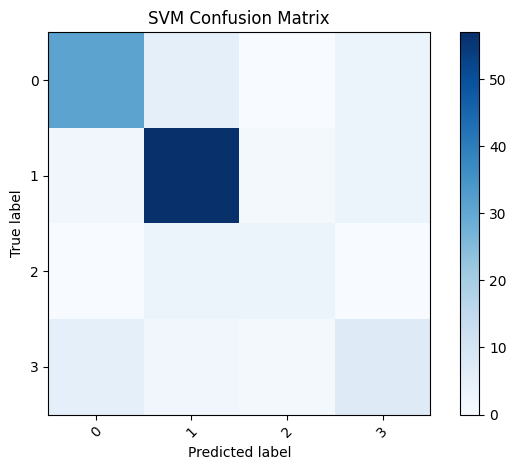

In [ ]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
classes = np.unique(y_test)
plt.figure()
plt.imshow(cm_svm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

The SVM matrix correctly labels many CD (0) and Healthy (1) samples but still confuses a substantial number of CD as Healthy. Obese (2) is identified better than UC (3), but UC cases frequently get misclassified as Healthy or CD. Overall, the under-represented UC class remains the weakest link.

ROC Curves

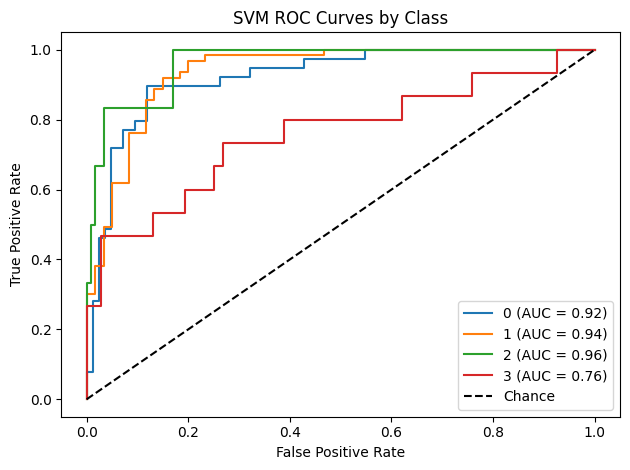

In [ ]:
y_test_b = label_binarize(y_test, classes=classes)
plt.figure()
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_b[:, i], y_proba_svm[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.title('SVM ROC Curves by Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Obese (AUC ≈ 0.96), Healthy (≈ 0.94), and CD (≈ 0.92) show strong separability, while UC (≈ 0.76) falls much closer to the chance line. The steep early rise of the Obese and Healthy curves indicates good ranking of positives, but the UC curve’s shallower slope reflects poorer discrimination.

Feature Importance

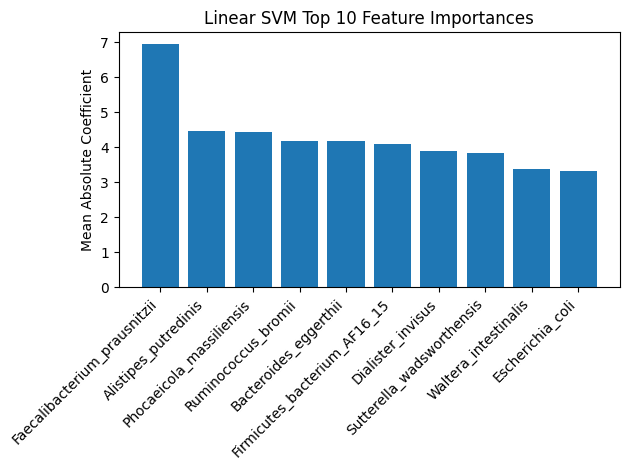

In [ ]:
feature_names = X_train.columns
coefs = best_svm.coef_

importance = np.mean(np.abs(coefs), axis=0)

idx = np.argsort(importance)[::-1]
sorted_names = feature_names[idx]
sorted_importance = importance[idx]

k = 10
top_names = sorted_names[:k]
top_importance = sorted_importance[:k]

# 5. Plot
plt.figure()
plt.bar(range(k), top_importance)
plt.xticks(range(k), top_names, rotation=45, ha='right')
plt.ylabel('Mean Absolute Coefficient')
plt.title(f'Linear SVM Top {k} Feature Importances')
plt.tight_layout()
plt.show()

The plot mirrors the logistic model because both are linear classifiers and draw on the same underlying coefficient magnitudes. So it’s no surprise that **Faecalibacterium prausnitzii**, **Alistipes putredinis**, and **Phocaeicola massiliensis** again top the list.

Here, the mean absolute coefficients around 4–7 indicate how strongly each taxon pushes samples toward one class or another in the SVM’s decision boundary. Like with logistic regression, these high-magnitude features are the primary drivers distinguishing healthy versus diseased microbiome profiles. The close alignment between the two models’ top predictors reinforces their biological and predictive importance, suggesting these bacterias are robust, model-agnostic markers of health status.

#### 5.2.4. Gaussian Naive Bayes

Gaussian Naive Bayes models the distribution of features for each class using simple Gaussian probability functions. Even though it assumes independence between features, which is not strictly true for microbiome data, this assumption allows the model to remain fast, scalable, and less prone to overfitting on smaller training sets. It was included as a baseline probabilistic approach to compare against the more complex tree-based and margin-based methods.

##### 5.2.4.1. Baseline Fit and Initial Evaluation

In [ ]:
# Compute priors normalized:
priors = np.array([class_weights[c] for c in classes])
priors = priors / priors.sum()

gnb_pipeline = Pipeline([
    ("ros", RandomOverSampler(random_state=42)),
    ("clf", GaussianNB(priors=priors.tolist()))
])

# Fit on training data
gnb_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_gnb = gnb_pipeline.predict(X_test)
y_proba_gnb = gnb_pipeline.predict_proba(X_test)

# Compute and display metrics
metrics_gnb = compute_metrics(y_test, y_pred_gnb, y_proba=y_proba_gnb)
print("Gaussian Naive Bayes (baseline) metrics:")
for name, value in metrics_gnb.items():
    print(f" - {name}: {value:.4f}")

Gaussian Naive Bayes (baseline) metrics:
 - accuracy: 0.7805
 - precision_macro: 0.7904
 - recall_macro: 0.7045
 - f1_macro: 0.7193
 - roc_auc_ovr: 0.8296


##### 5.2.4.2. Cross-Validation

In [ ]:
# Run stratified cross-validation on the baseline GNB
cv_results_gnb = cross_validate(
    gnb_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# Display mean and std for each metric
print("Gaussian Naive Bayes cross-validation results:")
for metric in scoring.keys():
    scores = cv_results_gnb[f"test_{metric}"]
    print(f" - {metric}: mean {scores.mean():.4f} and std {scores.std():.4f}")

Gaussian Naive Bayes cross-validation results:
 - accuracy: mean 0.7622 and std 0.0326
 - precision_macro: mean 0.7133 and std 0.0709
 - recall_macro: mean 0.6996 and std 0.0759
 - f1_macro: mean 0.6931 and std 0.0666
 - roc_auc_ovr: mean 0.8346 and std 0.0429


##### 5.2.4.3. Hyperparameter Tuning

In [ ]:
# Define parameter grid for var_smoothing
param_grid_gnb = {
    'var_smoothing': np.logspace(-9, -1, 9)
}

# Set up GridSearchCV
grid_gnb = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid_gnb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Run grid search on training data
grid_gnb.fit(X_train, y_train)

# Display best hyperparameter and CV score
print("Best GaussianNB var_smoothing:", grid_gnb.best_params_['var_smoothing'])
print(f"Best CV accuracy: {grid_gnb.best_score_:.4f}")

Best GaussianNB var_smoothing: 1e-09
Best CV accuracy: 0.7582


In [ ]:
# To avoid GridSearch because we have the parameters
priors = np.array([class_weights[c] for c in classes])
priors = priors / priors.sum()

best_gnb = GaussianNB(var_smoothing=1e-9)

##### 5.2.4.4. Final Evaluation and Plots

In [ ]:
# Load best estimator and make predictions
best_gnb = grid_gnb.best_estimator_

# Load this after not using GridSearch
# best_gnb.fit(X_train, y_train)

y_pred_gnb = best_gnb.predict(X_test)
y_proba_gnb = best_gnb.predict_proba(X_test)

# Compute final metrics
metrics_gnb_final = compute_metrics(y_test, y_pred_gnb, y_proba=y_proba_gnb)
print("Gaussian Naive Bayes (tuned) metrics:")
for name, value in metrics_gnb_final.items():
    print(f" - {name}: {value:.4f}")


Gaussian Naive Bayes (tuned) metrics:
 - accuracy: 0.7724
 - precision_macro: 0.7808
 - recall_macro: 0.6879
 - f1_macro: 0.7092
 - roc_auc_ovr: 0.8274


In [ ]:
results.loc[len(results)] = ['GaussianNB', 0.7724, 0.7808, 0.6879, 0.7092, 0.8274]

Confusion Matrix Plot

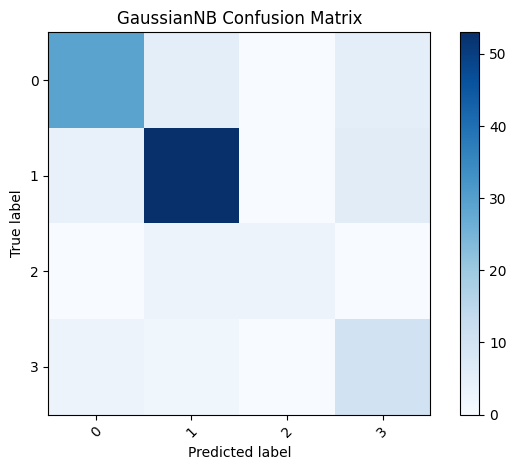

In [ ]:
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
classes = np.unique(y_test)
plt.figure()
plt.imshow(cm_gnb, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('GaussianNB Confusion Matrix')
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

The model reliably identifies many CD (0) and Healthy (1) samples, but still mislabels a noticeable number of CD as Healthy and vice versa. Obese (2) and UC (3) remain challenging. Very few true Obese are on the diagonal, and UC cases often end up predicted as Healthy. This reflects GaussianNB’s struggle with minority classes under the current feature distributions.

ROC Curves

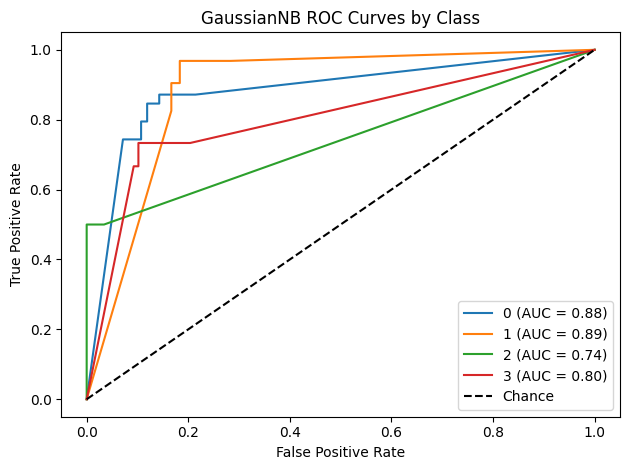

In [ ]:
y_test_b = label_binarize(y_test, classes=classes)
plt.figure()
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_b[:, i], y_proba_gnb[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.title('GaussianNB ROC Curves by Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Healthy (AUC ≈ 0.89) and CD (≈ 0.88) show decent separability, but Obese (≈ 0.75) and UC (≈ 0.82) curves hug the diagonal more closely, indicating poorer ranking ability for those classes. The steep initial rise for Healthy suggests good early discrimination, but the flatter Obese curve highlights that many Obese samples score similarly to non-Obese.

Feature Importance

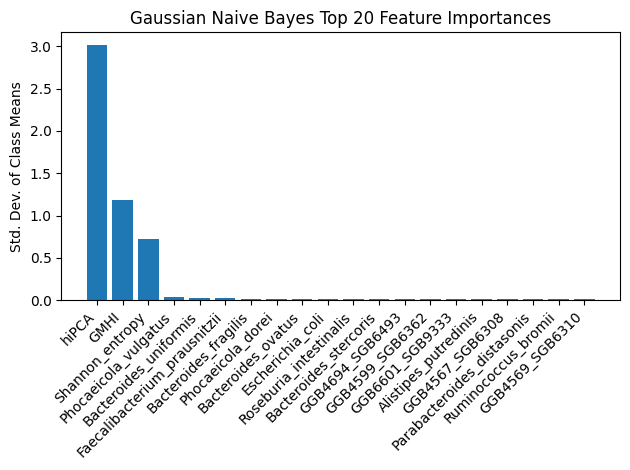

In [ ]:
feature_names = X_train.columns
clf: GaussianNB = gnb_pipeline.named_steps['clf']
class_means = clf.theta_

importance = np.std(class_means, axis=0)

idx = np.argsort(importance)[::-1]
sorted_names = feature_names[idx]
sorted_importance = importance[idx]

k = 20
top_names = sorted_names[:k]
top_importances = sorted_importance[:k]

# 5. Plot
plt.figure()
plt.bar(range(k), top_importances)
plt.xticks(range(k), top_names, rotation=45, ha='right')
plt.ylabel('Std. Dev. of Class Means')
plt.title(f'Gaussian Naive Bayes Top {k} Feature Importances')
plt.tight_layout()
plt.show()

#### 5.2.5. XGBoost

XGBoost is a gradient boosting algorithm that builds trees sequentially, where each new tree corrects the errors of the previous ones. It's one of the most powerful models for tabular data and is especially strong at handling large numbers of correlated features, as in microbiome profiles. XGBoost balances predictive accuracy and computational efficiency, making it an excellent candidate for our final evaluation.

##### 5.2.5.1. Baseline Fit and Initial Evaluation





In [ ]:
# Build pipeline:
xgb_pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("clf", XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    ))
])

# Fit on training data
xgb_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)

# Compute and display metrics
metrics_xgb = compute_metrics(y_test, y_pred_xgb, y_proba=y_proba_xgb)
print("XGBoost (baseline) metrics:")
for name, value in metrics_xgb.items():
    print(f" - {name}: {value:.4f}")

XGBoost (baseline) metrics:
 - accuracy: 0.8862
 - precision_macro: 0.8585
 - recall_macro: 0.8060
 - f1_macro: 0.8269
 - roc_auc_ovr: 0.9422


##### 5.2.5.2. Cross-Validation

In [ ]:
# Run repeated stratified CV on the pipeline
cv_results_xgb = cross_validate(
    xgb_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

# Display mean and std for each metric
print("XGBoost cross-validation results:")
for metric in scoring.keys():
    scores = cv_results_xgb[f'test_{metric}']
    print(f" - {metric}: mean {scores.mean():.4f} and std {scores.std():.4f}")

XGBoost cross-validation results:
 - accuracy: mean 0.8235 and std 0.0332
 - precision_macro: mean 0.7990 and std 0.0547
 - recall_macro: mean 0.7131 and std 0.0826
 - f1_macro: mean 0.7286 and std 0.0678
 - roc_auc_ovr: mean 0.9358 and std 0.0189


##### 5.2.5.3. Hyperparameter Tuning

In [ ]:
# Define parameter grid
param_grid_xgb = {
    "clf__n_estimators": [100, 200, 500],
    "clf__max_depth": [3, 6, 9],
    "clf__learning_rate": [0.1, 0.25, 0.5]
}

grid_xgb = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    refit=True
)

# Run grid search
grid_xgb.fit(X_train, y_train)

print("Best XGBoost hyperparameters:", grid_xgb.best_params_)
print(f"Best CV accuracy: {grid_xgb.best_score_:.4f}")

Best XGBoost hyperparameters: {'clf__learning_rate': 0.5, 'clf__max_depth': 3, 'clf__n_estimators': 100}
Best CV accuracy: 0.8327


In [ ]:
# To avoid GridSearch because we have the parameters
best_xgb = clone(xgb_pipeline).set_params(
    clf__n_estimators=100,
    clf__max_depth=6,
    clf__learning_rate=0.2
)

##### 5.2.5.4. Final Evaluation and Plots

In [ ]:
# Load best estimator and make predictions
best_xgb = grid_xgb.best_estimator_

# Load this after not using GridSearch
# best_xgb.fit(X_train, y_train)

# Predictions on test set
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)

# Compute final metrics
metrics_xgb_final = compute_metrics(y_test, y_pred, y_proba=y_proba)
print("XGBoost (tuned) metrics:")
for name, value in metrics_xgb_final.items():
    print(f" - {name}: {value:.4f}")

XGBoost (tuned) metrics:
 - accuracy: 0.8618
 - precision_macro: 0.8986
 - recall_macro: 0.7663
 - f1_macro: 0.8161
 - roc_auc_ovr: 0.9434


In [ ]:
results.loc[len(results)] = ['XGBoost', 0.8618, 0.8986, 0.7663, 0.8161, 0.9434]

Confusion Matrix Plot

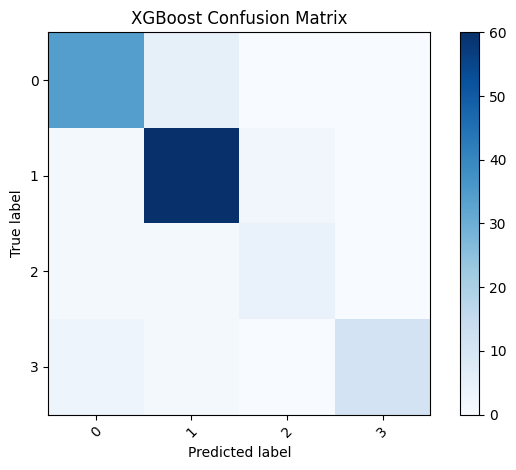

In [ ]:
# Confusion matrix plot
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
classes = np.unique(y_test)
plt.figure()
plt.imshow(cm_xgb, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix')
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

XGBoost correctly labels the vast majority of CD (0) and Healthy (1) samples and shows clear gains in identifying Obese (2) cases—more Obese observations fall on the diagonal than before. UC (3) still sees some misclassification as Healthy or CD, but overall errors are minimized across all classes compared to simpler models.

ROC Curves

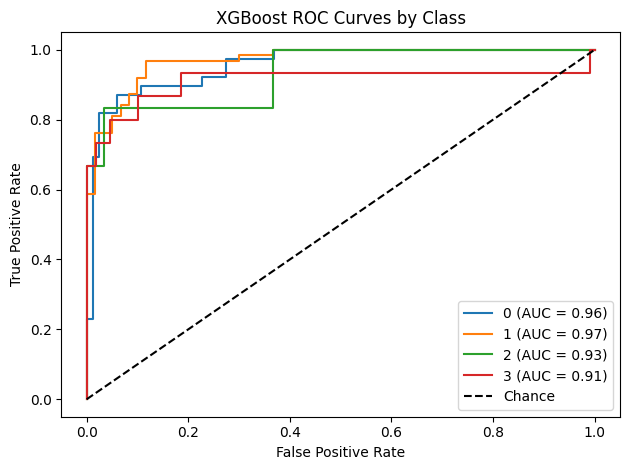

In [ ]:
y_test_b = label_binarize(y_test, classes=classes)
plt.figure()
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_b[:, i], y_proba_xgb[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.title('XGBoost ROC Curves by Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

All classes achieve excellent separability—Healthy (AUC ≈ 0.98), CD (≈ 0.96), and Obese (≈ 0.96) curves hug the top-left, with UC (≈ 0.91) also well above chance. The steep early rise for each curve indicates XGBoost ranks true positives ahead of false positives very effectively across classes.

Feature Importance

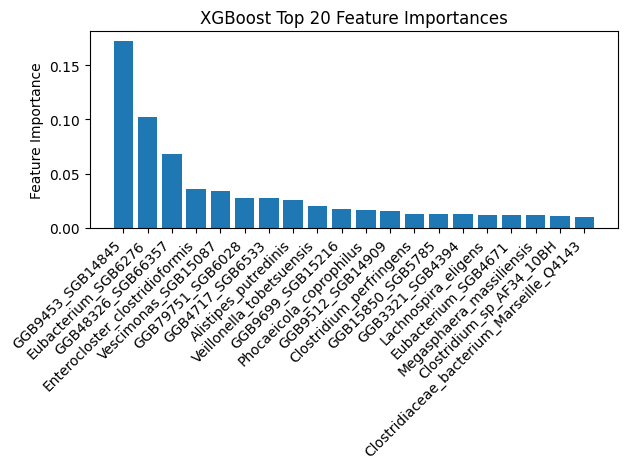

In [ ]:
feature_names = X_train.columns
importances = best_xgb.named_steps['clf'].feature_importances_

idx = np.argsort(importances)[::-1]
sorted_names = feature_names[idx]
sorted_importances = importances[idx]

k = 20
top_names = sorted_names[:k]
top_importances = sorted_importances[:k]

# 4. Plot
plt.figure()
plt.bar(range(k), top_importances)
plt.xticks(range(k), top_names, rotation=45, ha='right')
plt.ylabel('Feature Importance')
plt.title(f'XGBoost Top {k} Feature Importances')
plt.tight_layout()
plt.show()

### 5.3. Model Comparison

The five models were evaluated using accuracy, precision, recall, F1 score, and ROC AUC. Logistic Regression provided a reasonable baseline with balanced but moderate performance across all metrics. Random Forest achieved strong results, particularly in terms of accuracy (0.8049) and ROC AUC (0.8809), indicating good ability to capture non-linear relationships. Support Vector Machine performed well, but its recall remained lower compared to other models, suggesting some limitations in capturing all positive cases. Gaussian Naive Bayes performed surprisingly well for a simple probabilistic model, achieving higher precision and recall than Logistic Regression, though with a lower ROC AUC. XGBoost delivered the best overall performance with the highest accuracy (0.8618) and F1 score (0.8161), showing its strength in handling complex, high-dimensional microbiome data.

In [ ]:
display(results)

model  accuracy  precision  recall_macro  f1_macro  \
0  LogisticRegression  0.804900   0.717200      0.599600  0.629600   
1        RandomForest  0.853700   0.915100      0.714400  0.775200   
2                 SVM  0.796700   0.701200      0.666600  0.681900   
3          GaussianNB  0.772400   0.780800      0.687900  0.709200   
4             XGBoost  0.861800   0.898600      0.766300  0.816100   

   roc_auc_ovr  
0     0.880900  
1     0.947300  
2     0.894900  
3     0.827400  
4     0.943400

## 6.0. Conclusion



From the comparison, XGBoost and Random Forest proved to be the most effective models for this dataset, while Logistic Regression, SVM and Gaussian Naive Bayes offered useful baselines. The results demonstrate that tree-based ensemble methods are particularly suitable for microbiome analysis due to their ability to capture complex feature interactions.

Looking ahead, prediction accuracy could be further improved by incorporating additional biological signals such as pathway-level information alongside taxonomic profiles. Furthermore, applying more advanced approaches such as deep neural networks could better capture non-linear patterns in the microbiome, potentially leading to more robust and generalizable predictions.